In [1]:
import warnings
import math

import numpy as np
import pandas as pd
import datetime as dt
from datetime import date

import plotly.express as px

from tqdm import tqdm

warnings.filterwarnings('ignore')

from concurrent.futures import ThreadPoolExecutor

import statistics

# КНОПКА БАБЛО version 0.5

## Класс стратегии

In [2]:
class MyPosition:
    
    def __init__(self, amount: float, price_current: float, short: bool) -> None:
        """
        Инициализация объекта MyPosition.

        :param amount: Количество активов.
        :param price_current: Текущая цена актива.
        :param short: Флаг короткой позиции (True, если короткая; False, если длинная).
        """
        self._amount: float = amount
        self._price_current: float = price_current
        self._acc_fees: float = 0
        self._short: bool = short

    def update_state(self, price: float) -> None:
        """
        Обновление состояния позиции.

        :param price: Новая цена актива.
        """
        self._price_current = price
        if self._short:
            # Рассчитываем комиссию за перенос короткой позиции
            transfer_fee = abs(self._amount) * self._price_current * 0.00065
            self._acc_fees += transfer_fee

    def balance(self) -> float:
        """
        Вычисление баланса позиции.

        :return: Баланс позиции.
        """
        return self._amount * self._price_current

In [3]:
class Strategy:

    params = {'FEE': 0.0004}

    def __init__(self, states, start_equity):
        self._position = None
        self._states = states
        self._equity = start_equity
        self._margin_equity = 0

    def calc_upper_and_lower(self, i, states_ma, STD_COUNT_UP, STD_COUNT_DOWN):
        #mean_pos_ma = states_ma.head(i).mean()
        std_pos_ma = states_ma.head(i).std()
        pos_ma_upper = states_ma[i] + STD_COUNT_UP * std_pos_ma
        pos_ma_lower = states_ma[i] - STD_COUNT_DOWN * std_pos_ma
        return pos_ma_upper, pos_ma_lower

    def run(self, RISK, STD_COUNT_UP, STD_COUNT_DOWN, MA_COUNT):
        states_ma = self._states['pos'].rolling(window=MA_COUNT).mean() ###
        data = []

        for i in tqdm(range(len(self._states)), disable=True):
            if i < 10 * MA_COUNT:
                continue
            elif (i == 10 * MA_COUNT):
                state = self._states.loc[i]
                pos_ma = states_ma[i]
                prev_pos_ma = states_ma[i - 1]
                (pos_ma_upper, pos_ma_lower) = self.calc_upper_and_lower(i, states_ma, STD_COUNT_UP, STD_COUNT_DOWN)
            else:
                state = self._states.loc[i]
                pos_ma = states_ma[i]
                prev_pos_ma = states_ma[i - 1]

            b = 0
            s = 0

            if self._position:
                if state['price'] != self._states['price'][i - 1]:
                    self._position.update_state(state['price'])

                #if prev_pos_ma > pos_ma_lower and pos_ma < pos_ma_lower and self._position._short:
                if prev_pos_ma < pos_ma_upper and pos_ma > pos_ma_upper:
                    pos_ma_upper, pos_ma_lower = self.calc_upper_and_lower(i, states_ma, STD_COUNT_UP, STD_COUNT_DOWN)
                    if self._position._short:
                        b = 1
                #if prev_pos_ma < pos_ma_upper and pos_ma > pos_ma_upper and not self._position._short:
                if prev_pos_ma > pos_ma_lower and pos_ma < pos_ma_lower:
                    pos_ma_upper, pos_ma_lower = self.calc_upper_and_lower(i, states_ma, STD_COUNT_UP, STD_COUNT_DOWN)
                    if not self._position._short:
                        s = 1

                data.append([
                    state['datetime'],
                    state['price'],
                    self._equity - self._position._acc_fees,
                    self._position._short,
                    pos_ma_upper,
                    pos_ma_lower,
                    pos_ma,
                    b,
                    s
                ])

                if b:
                    self.close_short() 
                if s:
                    self.close_long()
            else:
                #if prev_pos_ma < pos_ma_lower and pos_ma > pos_ma_lower:
                if prev_pos_ma < pos_ma_upper and pos_ma > pos_ma_upper:
                    pos_ma_upper, pos_ma_lower = self.calc_upper_and_lower(i, states_ma, STD_COUNT_UP, STD_COUNT_DOWN)
                    self.open_long(state, RISK)
                    b = 1
                #if prev_pos_ma > pos_ma_upper and pos_ma < pos_ma_upper:
                if prev_pos_ma > pos_ma_lower and pos_ma < pos_ma_lower:
                    pos_ma_upper, pos_ma_lower = self.calc_upper_and_lower(i, states_ma, STD_COUNT_UP, STD_COUNT_DOWN)
                    self.open_short(state, RISK)
                    s = 1

                data.append([
                    state['datetime'],
                    state['price'],
                    self._equity,
                    -1,
                    pos_ma_upper,
                    pos_ma_lower,
                    pos_ma,
                    b,
                    s
                ])

        return pd.DataFrame(data, columns=['datetime', 'price', 'equity', 'short', 'pos_ma_upper', 'pos_ma_lower', 'pos_ma', 'buy', 'sell'])

    def open_short(self, state, RISK):
        if self._position:
            raise Exception(f'Cannot open position, already have one {self._position}')

        self._margin_equity += (
                np.floor((1 - self.params['FEE']) * RISK * self._equity / state['price']) * state['price'] -
                self.params['FEE'] * self._equity)

        amount = (-1) * np.floor((1 - self.params['FEE']) * RISK * self._equity / state['price'])

        self._position = MyPosition(amount, state['price'], True)

    def open_long(self, state, RISK):
        if self._position:
            raise Exception(f'Cannot open position, already have one {self._position}')

        self._margin_equity -= (
                np.floor((1 - self.params['FEE']) * RISK * self._equity / state['price']) * state['price'] +
                self.params['FEE'] * self._equity)

        amount = np.floor((1 - self.params['FEE']) * RISK * self._equity / state['price'])

        self._position = MyPosition(amount, state['price'], False)

    def close_short(self):
        if self._position._short == 0:
            raise Exception(f'Cannot close short position, it is long')

        self._equity += (
                self._margin_equity + (1 - self.params['FEE']) * self._position.balance() - self._position._acc_fees)
        self._margin_equity = 0
        self._position = None

    def close_long(self):
        if self._position._short == 1:
            raise Exception(f'Cannot close long position, it is short')

        self._equity += (
                self._margin_equity + (1 - self.params['FEE']) * self._position.balance() - self._position._acc_fees)
        self._margin_equity = 0
        self._position = None

In [4]:
def run_strategy(all_data_copy, std_count_up, std_count_down, ma_count):
    strategy = Strategy(all_data_copy, 10000000)
    df = pd.DataFrame(strategy.run(1, std_count_up, std_count_down, ma_count))
    df['equity'] = df['equity'] / df['equity'].iloc[0]
    final_total_balance = df['equity'].iloc[-1]
    return final_total_balance

# Тренировка

def train(all_data_copy1: pd.DataFrame) -> (float, float, float):
    # Грубый поиск параметров
    std_counts_up = np.arange(0.25, 2, 0.25)
    std_counts_down = np.arange(0.25, 2, 0.25)
    ma_counts = np.arange(500, 3000, 500)

    parameters = []
    final_total_balances = []

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = []

        for std_count_up in std_counts_up:
            for std_count_down in std_counts_down:
                for ma_count in ma_counts:
                    #print(std_count_up, std_count_down, ma_count)
                    future = executor.submit(run_strategy, all_data_copy1, std_count_up, std_count_down, ma_count)
                    futures.append((std_count_up, std_count_down, ma_count, future))

        for std_count_up, std_count_down, ma_count, future in futures:
            final_total_balance = future.result()
            parameters.append((std_count_up, std_count_down, ma_count))
            final_total_balances.append(final_total_balance)

    max_total_balance = max(final_total_balances)
    max_total_balance_index = final_total_balances.index(max_total_balance)
    corresponding_parameters = parameters[max_total_balance_index]

    # Уточнение параметров
    std_counts_up = np.arange(corresponding_parameters[0] - 0.1, corresponding_parameters[0] + 0.2, 0.1)
    std_counts_down = np.arange(corresponding_parameters[1] - 0.1, corresponding_parameters[1] + 0.2, 0.1)
    ma_counts = np.arange(corresponding_parameters[2] - 250, corresponding_parameters[2] + 500, 250)

    parameters = []
    final_total_balances = []

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = []

        for std_count_up in std_counts_up:
            for std_count_down in std_counts_down:
                for ma_count in ma_counts:
                    future = executor.submit(run_strategy, all_data_copy1, std_count_up, std_count_down, ma_count)
                    futures.append((std_count_up, std_count_down, ma_count, future))

        for std_count_up, std_count_down, ma_count, future in futures:
            final_total_balance = future.result()
            parameters.append((std_count_up, std_count_down, ma_count))
            final_total_balances.append(final_total_balance)

    max_total_balance = max(final_total_balances)
    max_total_balance_index = final_total_balances.index(max_total_balance)
    corresponding_parameters = parameters[max_total_balance_index]

    print(f"Maximum Total Balance: {max_total_balance}")
    print(f"Corresponding Parameters (std_count, std_timerange): {corresponding_parameters}")
    return corresponding_parameters

# Тест

def test(all_data_copy2: pd.DataFrame, std_count_up: float, std_count_down: float, ma_count: float) -> float:
    strategy = Strategy(all_data_copy2, 10000000)
    df = pd.DataFrame(strategy.run(1, std_count_up, std_count_down, ma_count))
    df['equity'] = df['equity'] / df['equity'].iloc[0]
    final_total_balance = df['equity'].iloc[-1]

    print(f'Test profit = {final_total_balance}')
    return final_total_balance

In [5]:
def clear_data(tiker):
    # Pos

    df = pd.read_csv(f'{tiker}_full_date.csv', sep=",")
    df = df.sort_values(by=['ticker', 'tradedate', 'tradetime']).drop_duplicates().reset_index().drop('index', axis=1)
    df['datetime'] = pd.to_datetime(df['tradedate'] + ' ' + df['tradetime']) 
    df = df.drop(['tradedate', 'tradetime'], axis=1) 
    df = df[df['clgroup'] == 'YUR'].reset_index().drop('index', axis=1)
    df = df[['datetime', 'pos']]
    data_pos = df

    # Price

    df = pd.read_csv(f'{tiker}_full_date_price.csv', sep=",")
    df.reset_index(inplace=True)
    df.rename(columns={'TRADEDATE': 'datetime'}, inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df[df['BOARDID']=='TQBR']
    df = df[['datetime', 'WAPRICE']]
    df.rename(columns={'WAPRICE': 'price'}, inplace=True)
    data_price = df

    # All data

    price_dict = dict(zip(data_price['datetime'].dt.date, data_price['price']))

    data_pos['price'] = data_pos['datetime'].dt.date.map(price_dict)

    all_data = data_pos.sort_values('datetime').drop_duplicates().dropna().reset_index().drop('index', axis=1)

    all_data_copy = all_data.copy()

    all_data_copy['date'] = all_data_copy['datetime'].dt.date

    # For train

    train_data = all_data_copy[all_data_copy['date'] < pd.to_datetime('2022-02-20').date()].reset_index().drop('index', axis=1)

    # For test

    test_data = all_data_copy[all_data_copy['date'] > pd.to_datetime('2022-12-31').date()].reset_index().drop('index', axis=1)

    return train_data, test_data

## Применение

In [6]:
#ticker_names=['sr', 'gz', 'yn', 'fv', 'lk']

ticker_names=['sr', 'gz', 'lk', 'vb', 'rn', 'mn', 'af', 'al', 'sn', 'yn', 'tt', 'nm', 'hy', 'me', 'fv', 'gk', 'mg']

#ticker_names=['vk']

for ticker in ticker_names:

    train_data, test_data = clear_data(ticker)

    corresponding_parameters = []

    corresponding_parameters = train(train_data)
    result = test(test_data, corresponding_parameters[0], corresponding_parameters[1], corresponding_parameters[2])

Maximum Total Balance: 1.415901383809778
Corresponding Parameters (std_count, std_timerange): (1.65, 1.75, 1250)
Test profit = 0.9263243110947
Maximum Total Balance: 1.5851736905441096
Corresponding Parameters (std_count, std_timerange): (0.15, 1.75, 750)
Test profit = 1.0
Maximum Total Balance: 1.3093584749871843
Corresponding Parameters (std_count, std_timerange): (0.15, 1.9500000000000002, 1500)
Test profit = 1.08062020268


FileNotFoundError: [Errno 2] No such file or directory: 'vb_full_date.csv'

## Отладочная печать

In [7]:
train_data, test_data = clear_data('tt')

strategy = Strategy(train_data, 10000000)
df = pd.DataFrame(strategy.run(1, 0.75, 0.15, 500))

px.line(df, x='datetime', y=['pos_ma', 'pos_ma_upper', 'pos_ma_lower']).show()

px.line(df, x='datetime', y='equity').update_xaxes(type='category').show()

up = pd.DataFrame(columns=['datetime', 'price'])
down = pd.DataFrame(columns=['datetime', 'price'])
for i in range(len(df['price'])):
    if df['buy'][i]:
        up.loc[len(up)] = df.iloc[i]
    elif df['sell'][i]:
        down.loc[len(down)] = df.iloc[i]
fig = px.line(df, x='datetime', y='price', title='График цен по времени', labels={'datetime': 'Дата и время', 'price': 'Цена'})
fig.add_trace(px.scatter(up, x='datetime', y='price').update_traces(marker=dict(color='green')).data[0])
fig.add_trace(px.scatter(down, x='datetime', y='price').update_traces(marker=dict(color='red')).data[0])
fig.update_xaxes(type='category')
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'tt_full_date.csv'

## Функция полезности

     std_count_up  std_count_down  ma_count  final_total_balance
0            0.25            0.25       500             0.953236
1            0.25            0.25      1000             0.929879
2            0.25            0.25      1500             0.907393
3            0.25            0.25      2000             0.876644
4            0.25            0.25      2500             0.741155
..            ...             ...       ...                  ...
240          1.75            1.75       500             0.844609
241          1.75            1.75      1000             0.828840
242          1.75            1.75      1500             1.054622
243          1.75            1.75      2000             1.107232
244          1.75            1.75      2500             0.906802

[245 rows x 4 columns]


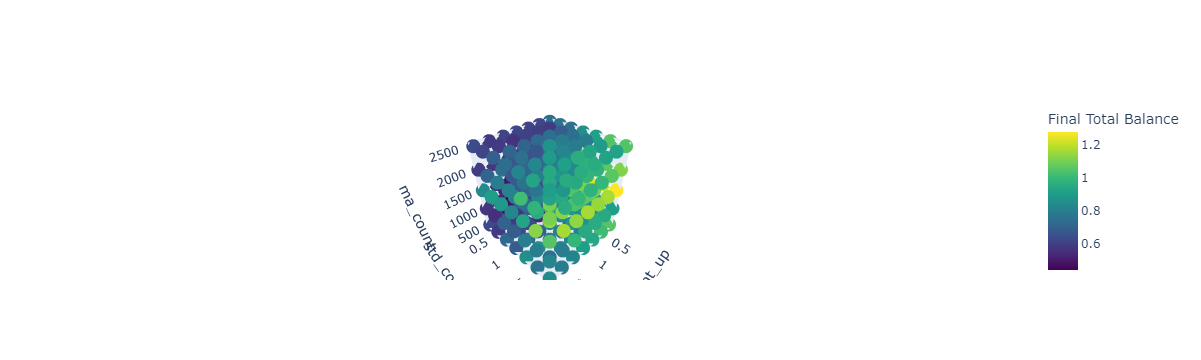

In [49]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

step_std_counts_up = 0.25
step_std_counts_down = 0.25
step_ma_counts = 500
std_counts_up = np.arange(0.25, 2, step_std_counts_up)
std_counts_down = np.arange(0.25, 2, step_std_counts_down)
ma_counts = np.arange(500, 3000, step_ma_counts)

parameters = []
final_total_balances = []

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    
    for std_count_up in std_counts_up:
        for std_count_down in std_counts_down:
            for ma_count in ma_counts:
                future = executor.submit(run_strategy, train_data, std_count_up, std_count_down, ma_count)
                futures.append((std_count_up, std_count_down, ma_count, future))

    for std_count_up, std_count_down, ma_count, future in futures:
        final_total_balance = future.result()
        parameters.append((std_count_up, std_count_down, ma_count))
        final_total_balances.append(final_total_balance)

# Преобразование в DataFrame для удобства работы с данными
df_plotly = pd.DataFrame(parameters, columns=['std_count_up', 'std_count_down', 'ma_count'])
df_plotly['final_total_balance'] = final_total_balances
print(df_plotly)


# Создание трехмерного графика в Plotly
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

scatter = go.Scatter3d(
    x=df_plotly['std_count_up'],
    y=df_plotly['std_count_down'],
    z=df_plotly['ma_count'],
    mode='markers',
    marker=dict(
        size=8,
        color=df_plotly['final_total_balance'],
        colorscale='Viridis',
        colorbar=dict(title='Final Total Balance')
    )
)

fig.add_trace(scatter)

# Наименование осей
fig.update_layout(scene=dict(
                    xaxis_title='std_count_up',
                    yaxis_title='std_count_down',
                    zaxis_title='ma_count')
                 )

# Отображение графика
fig.show()

In [76]:
import numpy as np
import pandas as pd
import statistics

def Utility_fun(income, var):
    return income/var

def Utility_assess(df_plotly, index_std_count_up, index_std_count_down, index_ma_count, len_std_counts_up, len_std_counts_down, len_ma_counts, radius):
    # Используем iloc для явного указания целочисленного индекса
    income = df_plotly.loc[
        (df_plotly['std_count_up'] == df_plotly['std_count_up'].iloc[index_std_count_up]) &
        (df_plotly['std_count_down'] == df_plotly['std_count_down'].iloc[index_std_count_down]) &
        (df_plotly['ma_count'] == df_plotly['ma_count'].iloc[index_ma_count])
    ]['final_total_balance'].values[0]

    index_std_count_up -= radius
    index_std_count_down -= radius
    index_ma_count -= radius

    array_income = np.array([])
    for i in range(2 * radius + 1):
        for j in range(2 * radius + 1):
            for k in range(2 * radius + 1):
                if (
                    (index_std_count_up + i >= 0) and
                    (index_std_count_down + j >= 0) and
                    (index_ma_count + k >= 0) and
                    (index_std_count_up + i < len_std_counts_up) and
                    (index_std_count_down + j < len_std_counts_down) and
                    (index_ma_count + k < len_ma_counts)
                ):
                    # print(df_plotly['std_count_up'])
                    # print(df_plotly['std_count_up'][index_std_count_up + i], df_plotly['std_count_down'][index_std_count_down + j], df_plotly['ma_count'][index_std_count_up + k])
                    # print(df_plotly.loc[(df_plotly['std_count_up'] == df_plotly['std_count_up'][index_std_count_up + i]) & (df_plotly['std_count_down'] == df_plotly['std_count_down'][index_std_count_down + j]) & (df_plotly['ma_count'] == df_plotly['ma_count'][index_std_count_up + k])]['final_total_balance'].values[0])
                    # Используем iloc для явного указания целочисленного индекса
                    array_income = np.append(
                        array_income,
                        df_plotly.loc[
                            (df_plotly['std_count_up'] == df_plotly['std_count_up'].iloc[index_std_count_up + i]) &
                            (df_plotly['std_count_down'] == df_plotly['std_count_down'].iloc[index_std_count_down + j]) &
                            (df_plotly['ma_count'] == df_plotly['ma_count'].iloc[index_ma_count + k])
                        ]['final_total_balance'].values[0]
                    )

    std_of_income = statistics.stdev(array_income) if len(array_income) >= 2 else 0
    Utility = Utility_fun(income, std_of_income)
    # print(Utility) 
    return Utility


radius = 2

array_utility = []
for index_std_count_up in range(len(std_counts_up)):
    for index_std_count_down in range(len(std_counts_down)):
        for index_ma_count in range(len(ma_counts)):
            array_utility.append(Utility_assess(df_plotly, index_std_count_up, index_std_count_down, index_ma_count, len(std_counts_up), len(std_counts_down), len(ma_counts), radius))

df_plotly['final_utility_balance'] = array_utility
print(df_plotly)
print(np.max(df_plotly['final_total_balance']), np.max(array_utility))


     std_count_up  std_count_down  ma_count  final_total_balance  \
0            0.25            0.25       500             0.953236   
1            0.25            0.25      1000             0.929879   
2            0.25            0.25      1500             0.907393   
3            0.25            0.25      2000             0.876644   
4            0.25            0.25      2500             0.741155   
..            ...             ...       ...                  ...   
240          1.75            1.75       500             0.844609   
241          1.75            1.75      1000             0.828840   
242          1.75            1.75      1500             1.054622   
243          1.75            1.75      2000             1.107232   
244          1.75            1.75      2500             0.906802   

     final_utility_balance  
0                49.978289  
1                32.418244  
2                12.016464  
3                11.797363  
4                10.071052  
..       

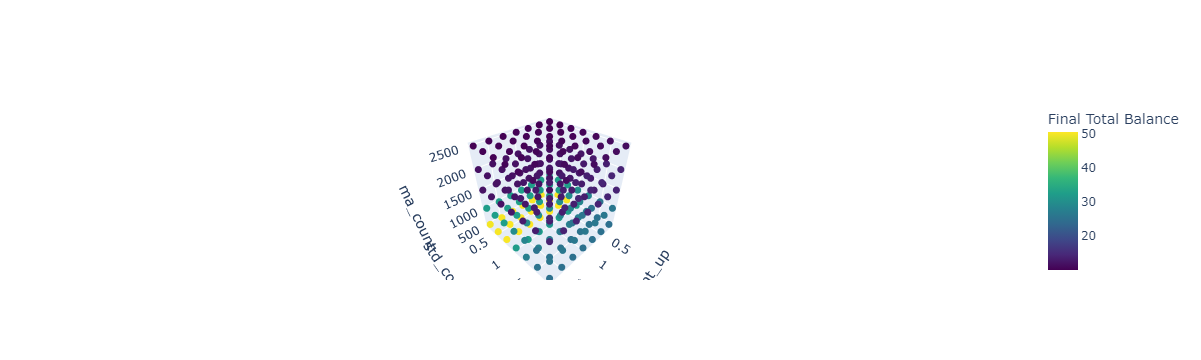

In [82]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Создание трехмерного графика в Plotly
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

scatter = go.Scatter3d(
    x=df_plotly['std_count_up'],
    y=df_plotly['std_count_down'],
    z=df_plotly['ma_count'],
    mode='markers',
    marker=dict(
        size=4,
        color=df_plotly['final_utility_balance'],
        colorscale='Viridis',
        colorbar=dict(title='Final Total Balance')
    ),
    text=df_plotly.apply(lambda row: f' final_utility_balance: {row["final_utility_balance"]}', axis=1)
)

fig.add_trace(scatter)

# Наименование осей
fig.update_layout(scene=dict(
                    xaxis_title='std_count_up',
                    yaxis_title='std_count_down',
                    zaxis_title='ma_count')
                 )

# Отображение графика
fig.show()
